In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use("classic")
from scipy.optimize import curve_fit
from scipy import stats
import os
import numpy as np
import glob

from itertools import combinations

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

In [7]:
import seaborn as sns

In [3]:
outpath_fig = './dataFolders/Output/Figures/v2/testColorScheme/'
path = './dataFolders/Output/Step6_FloralTypeConsolidatedData_AndFitParameters_v2/'

In [5]:
# Fix the bin number and edges based on ALL the data pooled together
shapes = ['c-1', 'c-2', 'c-3', 'c-10']
AllShapes = pd.DataFrame([])

for floralShape in shapes:
    file = glob.glob(path + floralShape + '_Alltrials.csv')[0]
    data = pd.read_csv(file)
    AllShapes = AllShapes.append(data)

In [6]:
# check for duplicates
AllShapes[AllShapes.duplicated()]

,Unnamed: 0,MothIn,MothOut,ProboscisDetect,DiscoveryTime,trialNum,name


# check N size for visit number

In [6]:
length_stats = pd.DataFrame()
df1 = []
df2 = []
for mothID, df in AllShapes.groupby('name'):
    df1.append(mothID)
    total_visit = len(df)
    df2.append(total_visit)
    
length_stats['name'] = df1
length_stats['total_visits'] = df2

# add a label for flower type
test = length_stats['name'].str.split('_', n = 1, expand = True)
length_stats.loc[:,'flower'] = test[0]

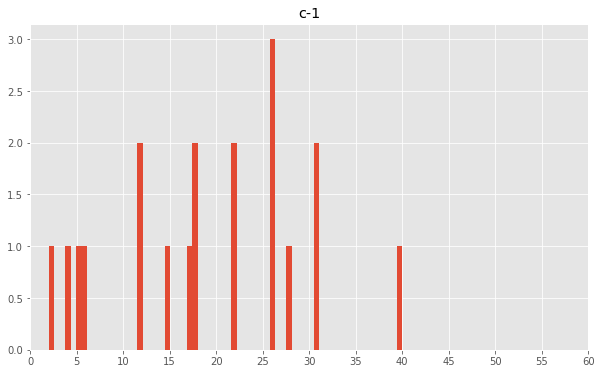

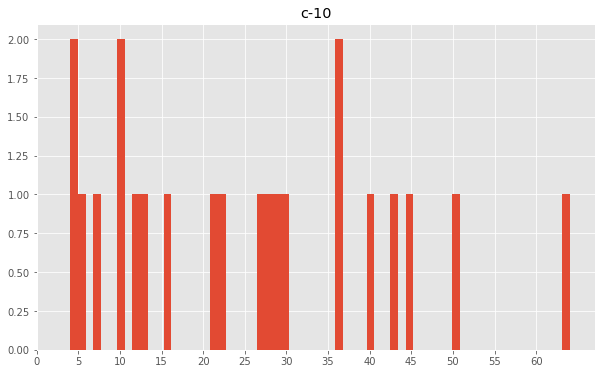

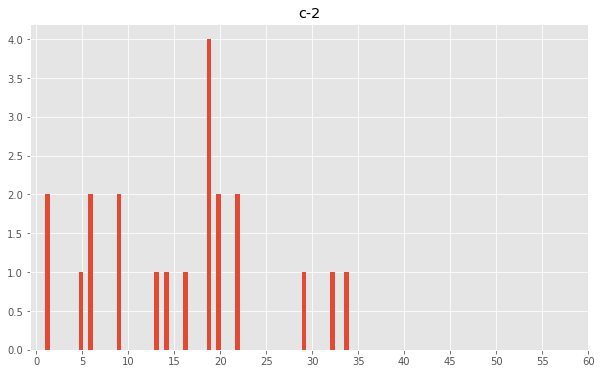

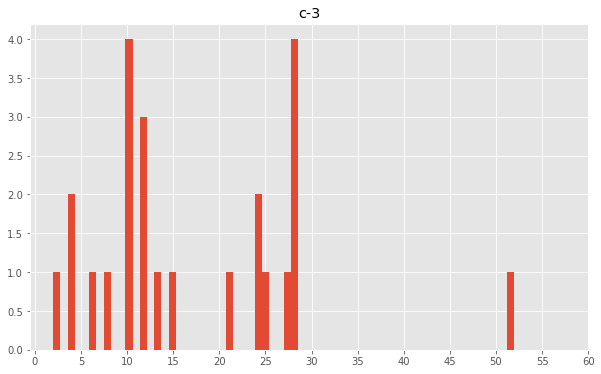

In [8]:
# how many visits for each moth
for f,temp in length_stats.groupby('flower'):
    fig, ax = plt.subplots(figsize = (10,6))
    ax.hist(temp.total_visits, bins = max(length_stats.total_visits))
    ax.set_xticks(np.arange(0, 64, 5))
    ax.set_title(f)

In [ ]:
# compare first and last visits

def selectvalue(lst, *indices):
    return (lst[i] for i in indices)

bla = []

for fl, df in AllShapes.groupby('flower'):
    for name, temp in df.groupby('name'):
        temp = temp.reset_index()
        discoveryTime = temp.DiscoveryTime.values * 1/100
        f = discoveryTime[0] 
        l = discoveryTime[-1]
        if len(temp) < 2:
            s = np.nan
            sl = np.nan
        else:
            s = discoveryTime[1]
            
        if len(temp) < 3:
            sl = np.nan
        else:
            sl = discoveryTime[-2]
        
        test = [(f, 'first', name, fl), (s, 'second', name, fl), 
                (sl, 'secondlast', name, fl), (l, 'last', name, fl)]
        
        bla.extend(test)

firstLast = pd.DataFrame(bla, columns = ['Time', 'label', 'name', 'flower'])

In [ ]:
# count non NaN entries in first and last visit
firstLast.count(axis = 0)

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

# Grouped boxplot
sns.boxplot(ax = ax, x="flower", y="Time", hue="label", data=firstLast, palette="Set1")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Remove nan to calculate the zscore

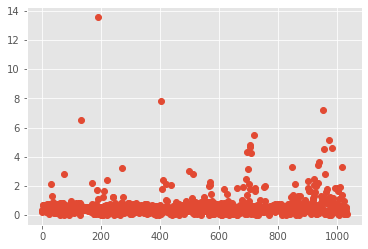

In [6]:
AllShapes_notnull = AllShapes[AllShapes.DiscoveryTime.notnull()].copy()
z = np.abs(stats.zscore(AllShapes_notnull.DiscoveryTime.values))
outlier_ID = z > 8
plt.plot(z, 'o') 

AllShapes_notnull.loc[:,'zscore'] = pd.Series(data = z, index = AllShapes_notnull.index)
AllShapes_notnull.loc[:,'outlier_ID'] = pd.Series(data = outlier_ID, index = AllShapes_notnull.index)

In [7]:
AllShapes_notnull.to_csv(path+'notnull_All_Data.csv')

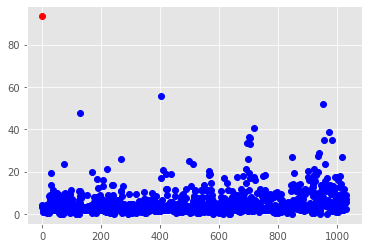

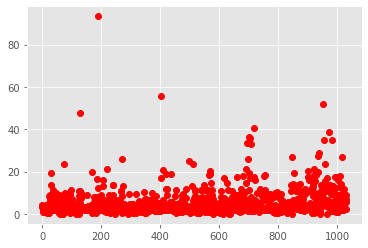

In [8]:
plt.plot(AllShapes_notnull.loc[AllShapes_notnull.outlier_ID == True, 'DiscoveryTime'].values/100,
         'o', color = 'red')
plt.plot(AllShapes_notnull.loc[AllShapes_notnull.outlier_ID == False, 'DiscoveryTime'].values/100,
         'o', color = 'blue')
plt.show()

ValuesConsidered = AllShapes_notnull.loc[:, 'DiscoveryTime'].values/100
plt.plot(ValuesConsidered, 'o', color = 'red')
plt.show()

In [9]:
notoutliers = AllShapes_notnull.loc[AllShapes_notnull['outlier_ID'] == False].copy()

# plot histogram for different bins

### bin the data in sets of N

In [10]:
# add a label for flower type
test = notoutliers.copy()
names = test['name'].str.split('_', n = 1, expand = True)
test.loc[:,'flower'] = names[0]

In [11]:
test.loc[:,'trialNum'] = test.loc[:,'trialNum']+1

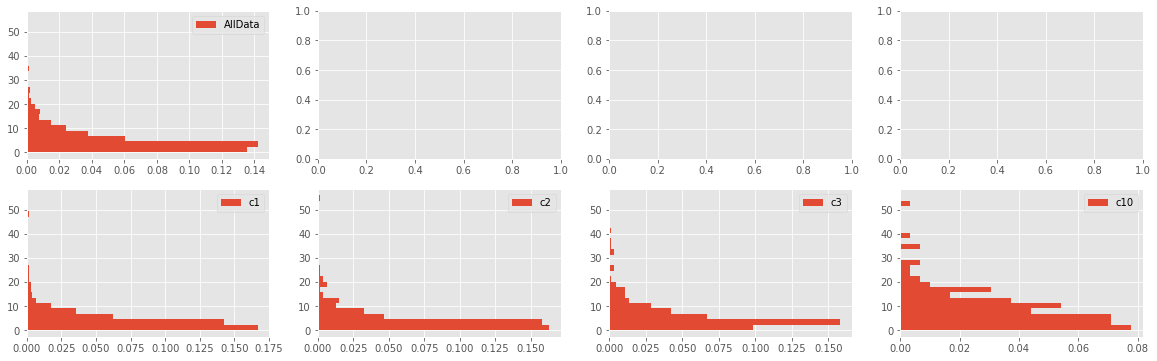

In [12]:
data = test

hist, bins = np.histogram(data['DiscoveryTime'].values/100, bins = 25)

fig, ax = plt.subplots(2,4, figsize = (20,6))
ax = ax.ravel()

ax[0].hist(data['DiscoveryTime'].values/100,
           bins, density = True, orientation = 'horizontal', label = 'AllData')
ax[0].legend()
ax[4].hist(data.DiscoveryTime[data.name.str.contains('c-1_')].values/100, 
           bins, density = True, orientation = 'horizontal' , label = 'c1')
ax[4].legend()
ax[5].hist(data.DiscoveryTime[data.name.str.contains('c-2_')].values/100,
           bins, density = True, orientation = 'horizontal', label = 'c2')
ax[5].legend()
ax[6].hist(data.DiscoveryTime[data.name.str.contains('c-3_')].values/100,
           bins, density = True, orientation = 'horizontal', label = 'c3')
ax[6].legend()
ax[7].hist(data.DiscoveryTime[data.name.str.contains('c-10_')].values/100,
           bins, density = True, orientation = 'horizontal', label = 'c10')
ax[7].legend()

# plt.savefig(outpath_fig + 'AllData_histogram.png')

In [13]:
binsize = 3
binn = np.arange(0,40, binsize)
binn = np.append(binn,max(data['trialNum'])+1)

label = [str(i) for i in binn][1:]

test['binnedBy3s']=pd.cut(test['trialNum'], binn, labels = label)

In [14]:
test.to_csv(path + 'notoutliers_binnedBy3s.csv')

# Box plot

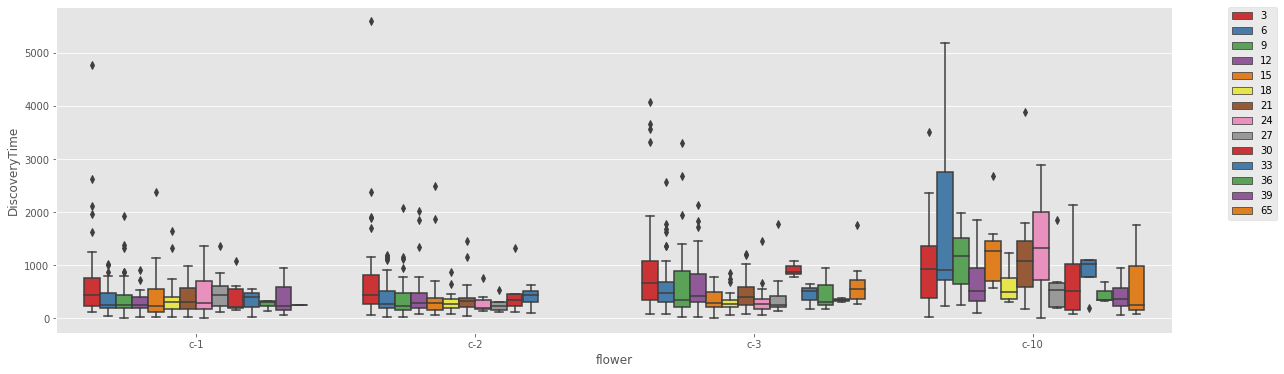

In [17]:
# plot as box plots 

fig, ax = plt.subplots(figsize = (20,6))

# Grouped boxplot
sns.boxplot(ax = ax, x="flower", y="DiscoveryTime", hue="binnedBy3s", data=test, palette="Set1")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig(outpath_fig + 'Histogram_eachBin_acrossFlowers.png')
# sns.plt.show()

# plot first - last one quarter for all shapes

In [ ]:
combined = pd.DataFrame()
# bin data 

for ff,data in test.groupby('flower'):
    m = max(data['trialNum'])
    last_fourth = m - m/4
      
    binsize = 3
    binn = np.arange(0,last_fourth, binsize)
    binn = np.append(binn,max(data['trialNum'])+1)
    print(ff)
    print(binn)
    label = [str(i) for i in binn][1:]

    data['binnedBy3s']=pd.cut(data['trialNum'], binn, labels = label)
#     test.head()
    combined = combined.append(data)

In [ ]:
bin_id = combined.binnedBy3s.unique()
bin_id

In [ ]:
# plot histogram
import matplotlib.cm as cm

colors = ['#1b9e77', '#fdae6b']
#1b9e77
#d95f02
#7570b3

data = combined

fig1, ax1 = plt.subplots(1,4, figsize=(15,10))
ax1 = ax1.ravel()

fig2, ax2 = plt.subplots(1,4, figsize=(15,10))
ax2 = ax2.ravel()

cc = 0
a = 0
for name, df in data.groupby('flower'):
    bin_id = df.binnedBy3s.unique()
    bin_compare = [bin_id[0], bin_id[-1]]
    idx = 0
    for binn in bin_compare:
        y = df.loc[(df.binnedBy3s == binn), 'DiscoveryTime'].values/100
        n = ax1[cc].hist(y,bins , density = True, histtype = 'bar',
                        cumulative = False,
                       orientation = 'vertical',
                       label = binn + ' ' + str(len(y)), 
                       color = colors[idx],
                      alpha = 1 - a,
                      linewidth = 2)
        ax2[cc].plot(n[1][1:], n[0])
        idx+=1
        a = 0.2
    ax1[cc].set_title(name)
    ax1[cc].legend()
    cc+=1
    

# plt.savefig(outpath_fig + 'Histogram-0toBinEdge-FirstLastHalf.png')

### Do statistics on the different distributions

In [ ]:
a = ['c-1', 'c-2', 'c-3', 'c-10']
b = ['first few', 'last quarter']
tuples = [(p1, p2) for p1 in a for p2 in b]
# tuples
index = pd.MultiIndex.from_tuples(tuples, names=['flowerType', 'MaxVisitNumber'])
# columns = number of bins

dist_bin = pd.DataFrame(data = None, index=index, columns = bins[:-1])
N_bin = pd.Series(data = None, index = index)
dist_cum = pd.DataFrame(data = None, index=index, columns = bins[:-1])
N_cum = pd.Series(data = None, index = index)

In [ ]:
# fill in the distributions binned as 0 - bin edge
data = combined
label = ['first few', 'last quarter']

cc= 0
for shape, df in data.groupby('flower'):
    bin_id = df.binnedBy3s.unique()
    bin_compare = [bin_id[0], bin_id[-1]]
    
    for ii, binEdge in enumerate(bin_compare):
        # fill in the df for binned data
        selected_df = df.loc[(df.binnedBy3s == binEdge), 'DiscoveryTime'].values/100
        n = len(selected_df)
        hist, _ = np.histogram(selected_df, bins = bins,
                           density = True)
        dist_bin.loc[(shape, label[ii]), :] = hist
        N_bin.loc[(shape, label[ii])] = n
        
        # fill in the df for cumulative data
        print(float(binEdge))
        selected_df = df.loc[(df.trialNum <= float(binEdge)), 'DiscoveryTime'].values/100
        n = len(selected_df)
        hist, _ = np.histogram(selected_df, bins = bins,
                           density = True)
        dist_cum.loc[(shape, label[ii]), :] = hist
        N_cum.loc[(shape, label[ii])]=n
        
    cc+=1 

dist_bin = dist_bin.astype('float64')
dist_cum = dist_cum.astype('float64')
dist_cum

In [ ]:
N_bin

In [ ]:
N_cum

In [ ]:
# plot all the distributions

f1, ax1 = plt.subplots(1,4, figsize = (15,10))
f2, ax2 = plt.subplots(1,4, figsize = (15,10))
ii= 0
for ff,df in dist_bin.groupby('flowerType'):
    ax1[ii].plot(df.columns, df.loc[(ff,'first few'),:], 
                 label = 'first few')
    ax1[ii].plot(df.columns, df.loc[(ff,'last quarter'),:],
                 label = 'last quarter')
    ax1[ii].legend()
    ax1[ii].set_title(ff)
    ii+=1
    
ii=0
for ff,df in dist_cum.groupby('flowerType'):
    ax2[ii].plot(df.columns, df.loc[(ff,'first few'),:], 
                 label = 'first few')
    ax2[ii].plot(df.columns, df.loc[(ff,'last quarter'),:], 
                 label = 'last quarter')
    ax2[ii].legend()
    ax2[ii].set_title(ff)
    ii+=1

In [ ]:
# make a dataframe to hold the stats

a = ['c-1', 'c-2', 'c-3', 'c-10']

stats_ks_df = pd.DataFrame(data = None, index=a, columns = ['first few to last quarter'])
stats_kl_df = pd.DataFrame(data = None, index=a, columns = ['first few to last quarter'])
stats_kl_df

In [ ]:
# do the stats and fill in the dfs

for ff, data in dist_cum.groupby('flowerType'):
        cdf_1 = data.loc[(ff, 'first few'), :].values
        cdf_2 = data.loc[(ff,'last quarter'), :].values
       
        _, ks_p = stats.ks_2samp(cdf_1, cdf_2)
        stats_ks_df.loc[ff] = ks_p
        
        kl_dist = stats.entropy(cdf_1, cdf_2)
        stats_kl_df.loc[ff] = kl_dist

In [ ]:
# def KL(a, b):
#     a = np.asarray(a, dtype=np.float)
#     b = np.asarray(b, dtype=np.float)

    
#     return np.sum(np.where(a != 0, a * np.log2(a / b), 0))

In [ ]:
stats_ks_df

In [ ]:
stats_kl_df

## PDF for early and late

In [10]:
test = pd.read_csv(path + 'notoutliers_binnedBy3s.csv')

In [11]:
earlyTrial = test[test.trialNum <= 4]
lateTrial = test[(test.trialNum > 20) & (test.trialNum <= 30)]

In [12]:
earlyTrial.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'MothIn', 'MothOut', 'ProboscisDetect',
       'DiscoveryTime', 'trialNum', 'name', 'zscore', 'outlier_ID', 'flower',
       'binnedBy3s'],
      dtype='object')

In [13]:
for flower, grp in earlyTrial.groupby('flower'):
    m = grp.name.unique()
    print('%s has %i moths and a total of %i visits' %(flower, len(m) , len(grp)))

c-1 has 19 moths and a total of 61 visits
c-10 has 14 moths and a total of 22 visits
c-2 has 20 moths and a total of 68 visits
c-3 has 21 moths and a total of 67 visits


In [14]:
for flower, grp in lateTrial.groupby('flower'):
    m = grp.name.unique()
    print('%s has %i moths and a total of %i visits' %(flower, len(m) , len(grp)))

c-1 has 9 moths and a total of 55 visits
c-10 has 10 moths and a total of 27 visits
c-2 has 5 moths and a total of 26 visits
c-3 has 9 moths and a total of 39 visits


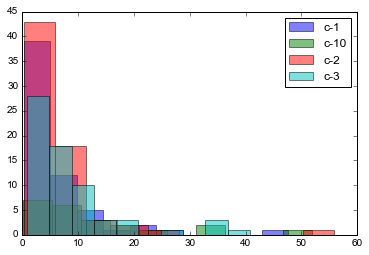

In [15]:
for flower, df in earlyTrial.groupby('flower'):
    plt.hist(df.DiscoveryTime/100, histtype='bar', label = flower, alpha = 0.5)
    plt.legend()

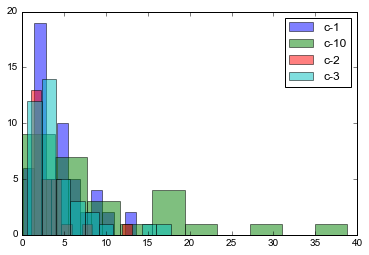

In [16]:
for flower, df in lateTrial.groupby('flower'):
    plt.hist(df.DiscoveryTime/100, histtype='bar', label = flower, alpha = 0.5)
    plt.legend()

# Using Scipy to generate the PDFs

In [17]:
# build the kde and compare the pdfs

# def kde_scipy(x, bandwidth=6):
#     """Kernel Density Estimation with Scipy"""
#     kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1))
#     return kde

def kde_scipy(x):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x)
    return kde

In [18]:
alldata = earlyTrial.DiscoveryTime/100
_,bins = np.histogram(alldata, bins = 100, density = True)
bin_center = 0.5*(bins[1:]+bins[:-1])
bin_center = np.linspace(0,70,200)
delta = np.diff(bin_center)[0]

In [19]:
early_df = pd.DataFrame(index = bin_center, columns = ['c-1', 'c-2', 'c-3', 'c-10'], dtype = 'float')
late_df = pd.DataFrame(index = bin_center, columns = ['c-1', 'c-2', 'c-3', 'c-10'], dtype = 'float')
SampleSize = pd.DataFrame(index = ['c-1', 'c-2', 'c-3', 'c-10'], columns = ['early', 'late'], dtype = 'float')

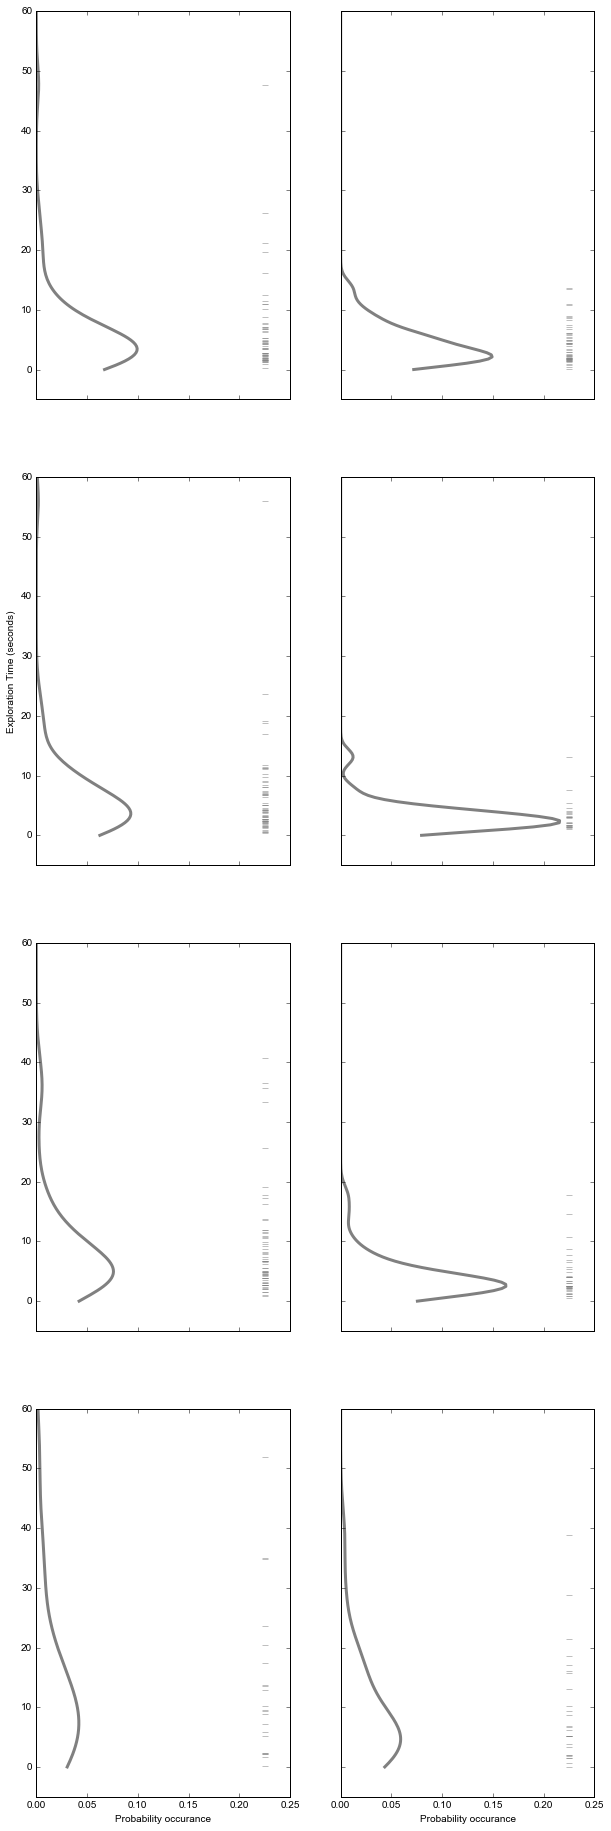

In [23]:
from scipy.stats import gaussian_kde

# plt.set_cmap('Spectral')
colorScheme = ['#e5e534', '#a1dab4', '#41b6c4', '#225ea8']
colorScheme = ['gray']*4

# f1, ax1 = plt.subplots(1,2,sharex = True, sharey = True, figsize = (15,20))
f2, ax2 = plt.subplots(4,2,sharex = True, sharey = True, figsize = (10, 8*4))

offset = -0.025
cc = 0
for f, df in earlyTrial.groupby('flower', sort = False):

    data = df.DiscoveryTime/100   
    SampleSize.loc[f,'early'] = len(data)
    kde = kde_scipy(data)
    
    temp = kde.pdf(bin_center)
    temp /= delta * np.sum(temp)
    early_df.loc[:,f]=temp
    
    p = ax2[cc,0].plot(temp, bin_center, label = f, color = colorScheme[cc], linewidth = 3)
    c = p[0].get_color()
    ax2[cc,0].plot([0.25 + offset]*len(data), data , '_', color = colorScheme[cc])

    cc+=1

cc= 0
for f, df in lateTrial.groupby('flower', sort = False):

    data = df.DiscoveryTime/100    
    SampleSize.loc[f,'late'] = len(data)
    kde = kde_scipy(data)
    
    temp = kde.pdf(bin_center)
    temp /= delta * np.sum(temp)
    late_df.loc[:,f]=temp
    
    p = ax2[cc,1].plot(temp, bin_center, label = f, color = colorScheme[cc], linewidth = 3)
    c = p[0].get_color()
    ax2[cc,1].plot([0.25 + offset]*len(data), data, '_', color = colorScheme[cc])
    cc+=1
    

ax2[3,0].set_xlabel('Probability occurance')
ax2[3,1].set_xlabel('Probability occurance')
ax2[1, 0].set_ylabel('Exploration Time (seconds)')
ax2[0,0].set_ylim(-5, 60)
ax2[1,0].set_ylim(-5, 60) 
# ax
plt.savefig(outpath_fig + 'PDFs_earlyLateVisits_separatePanel_vertical_v3.pdf')

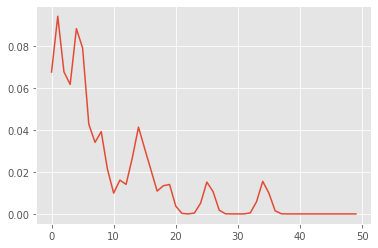

In [22]:
kde.set_bandwidth(.1)
plt.plot(kde.pdf(bin_center))

In [18]:
SampleSize

,early,late
c-1,61.0,55.0
c-2,68.0,26.0
c-3,67.0,39.0
c-10,22.0,27.0


In [39]:
shapes = ['c-1', 'c-2', 'c-3', 'c-10']
mystats_early = pd.DataFrame(index = list(combinations(shapes,2)), columns = ['ks', 'kl'])
mystats_late = pd.DataFrame(index = list(combinations(shapes,2)), columns = ['ks', 'kl'])

In [59]:
early_df.astype('float64')
late_df.astype('float64')

for bla in combinations(shapes,2):
    f1, f2 = bla
    
    #early visits
    dist1 = early_df.loc[:,f1].values
    dist2 = early_df.loc[:,f2].values

    _,early_ks = stats.ks_2samp(dist1,dist2 )
    mystats_early.loc[bla, 'ks'] = early_ks
    
    early_kl = stats.entropy(dist1, dist2)
    mystats_early.loc[bla, 'kl'] = early_kl
    
    # later visits
    dist1 = late_df.loc[:,f1].values
    dist2 = late_df.loc[:,f2].values

    _,late_ks = stats.ks_2samp(dist1,dist2 )
    mystats_late.loc[bla, 'ks'] = late_ks
    
    late_kl = stats.entropy(dist1, dist2)
    mystats_late.loc[bla, 'kl'] = late_kl

In [60]:
mystats_early

,ks,kl
"(c-1, c-2)",0.0217078,0.0156409
"(c-1, c-3)",0.0391946,0.0472468
"(c-1, c-10)",1.58143e-06,0.176224
"(c-2, c-3)",0.0115117,0.0668916
"(c-2, c-10)",4.92912e-07,0.20239
"(c-3, c-10)",0.0391946,0.075039


In [61]:
mystats_late

,ks,kl
"(c-1, c-2)",0.966746,0.0325351
"(c-1, c-3)",0.997711,0.00594696
"(c-1, c-10)",1.38679e-05,0.548506
"(c-2, c-3)",0.869262,0.0101894
"(c-2, c-10)",1.45346e-07,0.717861
"(c-3, c-10)",4.80753e-06,0.617768


In [62]:
pair_compare = pd.DataFrame(index = shapes, columns = ['ks', 'kl'], dtype = 'float')
for shape in shapes:
    p1 = early_df.loc[:,shape].values
    q1 = late_df.loc[:,shape].values
    
    kl = stats.entropy(p1,q1)
    _,ks = stats.ks_2samp(p1,q1)
    
    pair_compare.loc[shape, 'ks'] = ks
    pair_compare.loc[shape, 'kl'] = kl

In [63]:
pair_compare

,ks,kl
c-1,4.929119e-07,0.333572
c-2,1.581426e-06,0.395801
c-3,9.909301e-05,0.587610
c-10,1.123852e-01,0.057840


In [43]:
# save all the df we will need later
early_df.to_csv(path + 'first3bins.csv')
late_df.to_csv(path + '20To30bin.csv')
mystats_early.to_csv(path + 'Stats_AcrossShapeEarly.csv')
mystats_late.to_csv(path + 'Stats_AcrossShapeLate.csv')
pair_compare.to_csv(path + 'Stats_WithShapeEarlyLate.csv')